<a href="https://colab.research.google.com/github/codingfabi/COUGHVID/blob/data_preprocessing_spectograms/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import skimage.io
import cv2
import tensorflow as tf
import csv

from google.colab.patches import cv2_imshow

In [177]:
import warnings
warnings.filterwarnings("ignore")

In [178]:
class CoughDetector(tf.keras.Model):

  def __init__(self):
    super(CoughDetector, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLMC(tf.keras.Model):

  def __init__(self):
    super(DTLMC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(3,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLBC(tf.keras.Model):

  def __init__(self):
    super(DTLBC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x



With the library 'librosa', we can easily handle audio files and create data arrays and spectograms out of the cough samples:

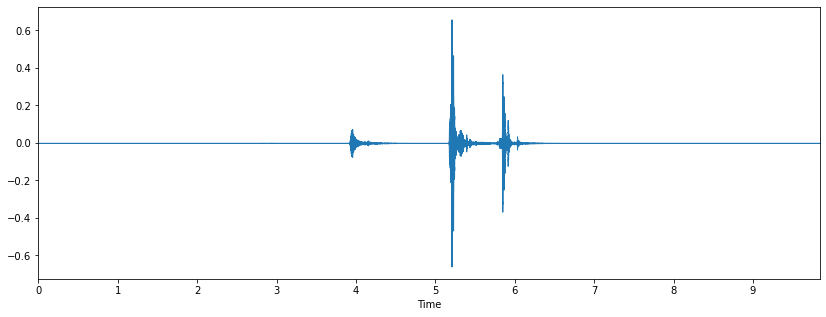

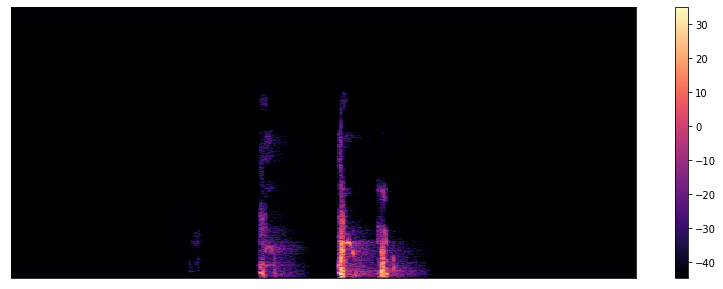

In [179]:
x , sr = librosa.load('./drive/MyDrive/COUGHVID/testcough.webm')
plt.figure(figsize=(14,5))
librosa.display.waveplot(x)
x_new = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_new))

plt.figure(figsize=(14,5))
librosa.display.specshow(x_db, sr=sr)
plt.colorbar()

We create some helper functions to handle file extractions and spectogram image creation:

In [180]:
def load_json_from_drive(filename):
  with open('./drive/MyDrive/COUGHVID/' + filename) as json_file:
    data = json.load(json_file)
  
  return data

def load_soundfile_from_drive(filename):
  x , sr = librosa.load('./drive/MyDrive/COUGHVID/' + filename)
  return x, sr

def jsonFileNames(path='./drive/MyDrive/COUGHVID/'):
    """
    Returns the names of all .json files in the path as list of strings
    """
    tmp = !ls './drive/MyDrive/COUGHVID'
    filenames = np.array(tmp)
    jsonFileNames = []
    for filename in filenames:
      if ".json" in filename:
        jsonFileNames.append(filename)
    return jsonFileNames

def hasStatusAttribute(fileName, path='./drive/MyDrive/COUGHVID/'):
    """
    Returns a boolean indicating if the specified json file has a 'status' key    
    """
    with open(os.path.join(path,fileName)) as file:
        data = json.load(file)
        hasStatusAttribute = 'status' in data
        return hasStatusAttribute

def valueFromJsonParser(fileName, key, path='./drive/MyDrive/COUGHVID/'):
    """
    Returns the status of the specified json file 
    """    
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        return data[str(key)]

def generateMelSpectrogram(fileName, inputPath='./drive/MyDrive/COUGHVID/'):
    """
    Generates Mel Spectogram from cough sample.
    Note: multiply values by -1 to avoid black images during png conversion
    """
    x, sr = load_soundfile_from_drive(fileName)
    M = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
    M_db = librosa.power_to_db(M, ref=np.max) * -1
    dim = (320,240) # resize to dimensions from https://www.sciencedirect.com/science/article/pii/S2352914820303026
    resized = cv2.resize(M_db, dim, interpolation=cv2.INTER_LINEAR)

    return resized

''' def coughDetectionIsAboveThreshold(fileName, threshold, path='./drive/MyDrive/COUGHVID/'):
    coughDetectionIsAboveThreshold = False
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        if ('cough_detected' in data):
            if float(data['cough_detected'])> threshold:
                coughDetectionIsAboveThreshold = True
    return coughDetectionIsAboveThreshold '''


def coughDetectionIsAboveThreshold(fileName, threshold, path='./drive/MyDrive/COUGHVID/'):
    coughDetectionIsAboveThreshold = False
    if float(valueFromJsonParser(fileName,'cough_detected',path)) > threshold:
        coughDetectionIsAboveThreshold = True
    return coughDetectionIsAboveThreshold

def generateAllMelSpectrogramsAndLabelsFile(outputPath, threshold, inputPath='./drive/MyDrive/COUGHVID/'):
    LabelsList = []
    ThresholdList = []
    filenames = jsonFileNames(inputPath)
    for filename in jsonFileNames(inputPath):
      try:
        if hasStatusAttribute(filename,inputPath) and coughDetectionIsAboveThreshold(filename, threshold, inputPath):
          LabelsList.append(valueFromJsonParser(filename,'status',inputPath))
          ThresholdList.append(valueFromJsonParser(filename,'cough_detected',inputPath))
          audioFileName = filename.strip(".json")+".webm"
          if os.path.isfile(inputPath + audioFileName) == False:
            audioFileName = filename.strip(".json")+".ogg"
          melSpectrogram = generateMelSpectrogram(audioFileName,inputPath)
          melSpectrogramFileName = filename.strip(".json")+".png"
          melSpectrogramFilePath = os.path.join(outputPath,melSpectrogramFileName)
          cv2.imwrite(melSpectrogramFilePath, melSpectrogram)
      except FileNotFoundError:
        print('File was not found')
        continue
    with open(os.path.join(outputPath,"LabelsAndThresholds.csv"), 'w') as file:
      wr = csv.writer(file)
      wr.writerow(LabelsList)
      wr.writerow(ThresholdList)

def readAllMelSpecs():
  data = []
  tmp = !ls './drive/MyDrive/COUGHVID/MelDiagrams'
  files = np.array(tmp)
  for file in files:
    if '.png' in file:
      filepath = './drive/MyDrive/COUGHVID/MelDiagrams/' + file
      tmp = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
      data.append(tmp)

  return np.array(data)

def oneHotEncoding(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1,0,0])
    elif label == 'symptomatic':
      oneHotList.append([0,1,0])
    elif label == 'COVID-19':
      oneHotList.append([0,0,1])

  return np.array(oneHotList)

def convertCSVToArrays(filepath = './drive/MyDrive/COUGHVID/MelDiagrams/LabelsAndThresholds.csv'):

  labels = []
  coughValues = []

  with open(filepath, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
      for index, row in enumerate(spamreader):
          entries = row[0].split(',')
          if index == 0:
            labels = entries
          else:
            coughValues = entries
  
  return labels, coughValues

In [181]:
generateAllMelSpectrogramsAndLabelsFile('./drive/MyDrive/COUGHVID/MelDiagrams', .8)

In [182]:
labels, _ = convertCSVToArrays()

X = readAllMelSpecs()
Y = oneHotEncoding(labels)


print(X.shape)
print(Y.shape)

(15, 240, 320)
(15, 3)


--------- preprocessing done ------------

In [183]:
# lets keep this, maybe we will need this
def transform_function(frequency):
  return 2595 * np.log10(1 + (frequency/700))

  